# 1. Collect and explore the data

## Goals

This notebook aims to explore, clean, and structure the options data that will be used in the pricing modeling project (Black-Scholes, Heston, etc.).

Therefore, this notebook analyzes:
- Structure and characteristic of the option market-
- Relevant filters to ensure data quality
- Calculation of useful features as `mid price`, `spread`, `time to maturity (T)` and `interest free rate`

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm

sns.set(style="darkgrid")
%matplotlib inline

## 1.1. Downloading the data.

In this notebook section, I will download the data from YahooFinance. The financial asset choose is the `^SPX` ticker. The time to maturity is also computed.

In [2]:
ticker_symbol = "^SPX"
ticker = yf.Ticker(ticker_symbol)

spot_price = ticker.history(period="1d")['Close'].iloc[-1]

expirations = ticker.options
print(f"Available expirations from {expirations[0]} to {expirations[len(expirations)-1]}")

Available expirations from 2025-07-31 to 2030-12-20


In [3]:
options_df = []

for expiry in expirations[1:]:
    try:
        option_chain = ticker.option_chain(expiry)
        expiry_date = datetime.strptime(expiry, "%Y-%m-%d")
        T = (expiry_date - datetime.today()).days/365.0
        

        for df, opt_type in zip([option_chain.calls, option_chain.puts], ["call", "put"]):
            df = df.copy()
            df["Type"] = opt_type
            df["T"] = T
            options_df.append(df)
        
    except Exception as e:
        print(f"Error with expriry {expiry}: e")

options_df = pd.concat(options_df, ignore_index=True)
options_df.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,Type,T
0,SPXW250801C03600000,2025-07-09 13:36:40+00:00,3600.0,2665.10,2809.9,2828.0,0.00000,0.000000,NaN,1.0,3.862915,True,REGULAR,USD,call,0.0
1,SPXW250801C04000000,2025-07-11 16:24:31+00:00,4000.0,2267.07,2411.3,2418.7,0.00000,0.000000,30.0,338.0,3.019534,True,REGULAR,USD,call,0.0
2,SPXW250801C04500000,2025-07-31 13:42:24+00:00,4500.0,1903.47,1907.6,1925.7,23.22998,1.235480,1.0,5.0,2.420841,True,REGULAR,USD,call,0.0
3,SPXW250801C04700000,2025-07-31 03:50:20+00:00,4700.0,1724.70,1705.5,1722.1,46.70996,2.783685,4.0,2.0,2.031133,True,REGULAR,USD,call,0.0
4,SPXW250801C04800000,2025-07-31 02:39:48+00:00,4800.0,1622.65,1603.8,1622.1,45.51001,2.885604,2.0,2.0,1.866334,True,REGULAR,USD,call,0.0


## 1.2. Data preprocessing

In this section, I apply relevant filters to guarantee that: 
- Options have enough liquidity (`openInterest > X`)
- Do not have inconsistencies (`bid > ask`)
- Options are **vanilla**

The `mid price` y `spread` are also computed for each action. The `interest free rate` is interpolated from USA treasure bill interest.

In [4]:
def filter_options(df, min_open_interest=100):
    useful_cols = ['strike', 'bid', 'ask', 'lastPrice', 'openInterest', 'impliedVolatility', 'Type', 'T']
    df = df[useful_cols].copy()
    df = df[df['openInterest'] > min_open_interest]
    df = df[df['bid'] > 0]
    df = df[df['T']<= 1]
    df = df[df['ask'] > 0]
    df = df[df['bid'] < df['ask']]
    df["mid"] = (df["bid"] + df["ask"]) / 2
    df["spread"] = df["ask"] - df["bid"]
    return df

options_df = filter_options(options_df)
print(options_df.shape)

(6208, 10)


In [5]:
#interest free rates 29-july-2025
tenors = np.array([0.25, 0.5, 1.0, 2.0, 5.0])
rates = np.array([0.0433, 0.0426, 0.0408, 0.0391, 0.0396])

def interp_rate(T, tenors, rates):
    return np.interp(T, tenors, rates)

options_df['risk_free_rate'] = options_df['T'].apply(lambda T: interp_rate(T, tenors, rates))
options_df['Underlying_price'] = spot_price
print(options_df.shape[0])
options_df.head()

6208


,strike,bid,ask,lastPrice,openInterest,impliedVolatility,Type,T,mid,spread,risk_free_rate,Underlying_price
1,4000.0,2411.3,2418.7,2267.07,338.0,3.019534,call,0.0,2415.00,7.4,0.0433,6408.129883
6,5000.0,1411.2,1415.8,1388.24,843.0,1.660646,call,0.0,1413.50,4.6,0.0433,6408.129883
20,5575.0,838.7,842.6,801.86,1001.0,1.076939,call,0.0,840.65,3.9,0.0433,6408.129883
29,5700.0,713.6,717.0,703.47,136.0,0.925690,call,0.0,715.30,3.4,0.0433,6408.129883
36,5800.0,614.5,617.7,566.46,108.0,0.829195,call,0.0,616.10,3.2,0.0433,6408.129883


## 1.3. Initial visulatization

Through a scatter plot, this section allow me to visualize the distribution of options across the strike value and time to maturity.

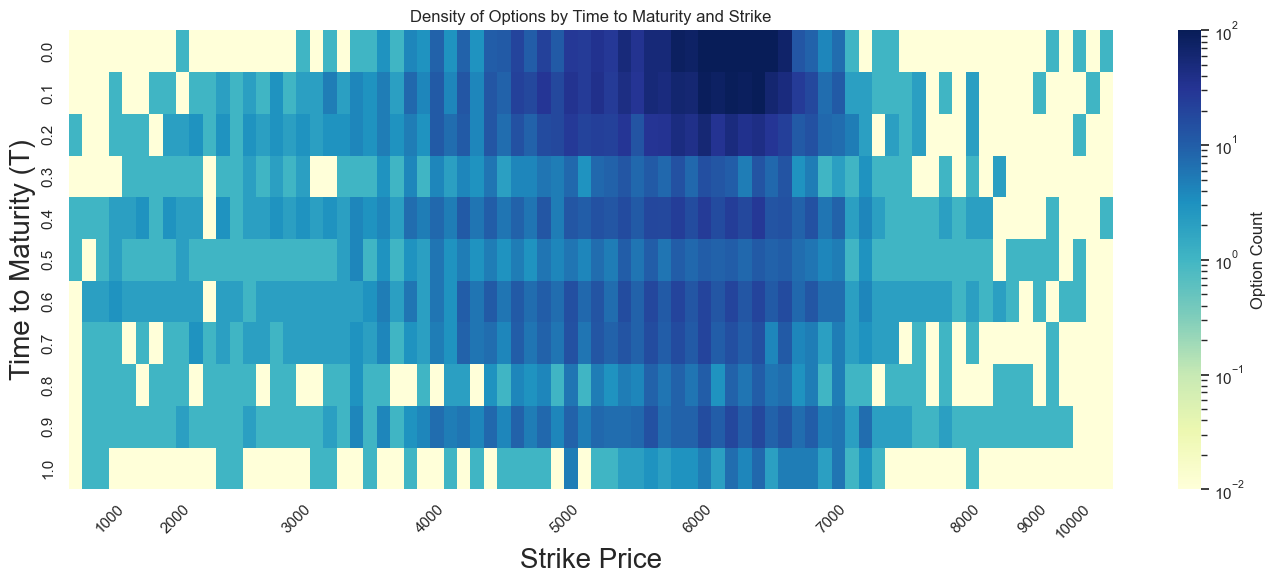

In [6]:
df_plot = options_df.copy()
df_plot['strike_bin'] = df_plot['strike'].round(-2)  
df_plot['T_bin'] = df_plot['T'].round(1)            

counts_pivot = df_plot.groupby(['T_bin', 'strike_bin']).size().unstack(fill_value=1e-9)
plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    counts_pivot,
    cmap='YlGnBu',
    norm=LogNorm(vmin=0.01, vmax=100),
    cbar_kws={'label': 'Option Count'}
)

xticks = np.arange(0, 10001, 1000)
xticks_in_data = [x for x in xticks if x in counts_pivot.columns]
xtick_locs = [list(counts_pivot.columns).index(x) for x in xticks_in_data]

plt.xticks(xtick_locs, xticks_in_data, rotation=45)

plt.title("Density of Options by Time to Maturity and Strike")
plt.xlabel("Strike Price", fontsize = 20)
plt.ylabel("Time to Maturity (T)", fontsize = 20)
plt.tight_layout()
plt.show()

## 1.4. Data saving

This section saves the data to a `.csv` file in the `Data/` directory.

In [7]:
output_path = "../data/options_cleaned.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
options_df.to_csv(output_path, index=False)
print(f"Saved cleaned option chain to: {output_path}")

Saved cleaned option chain to: ../data/options_cleaned.csv


# 1.5. Summary

- Data collected and stored for multiple S&P500 options.
- Initial preprocessing discarding non-relevant data.
- Calc useful metrics such as related interest free rate and time to maturity.
- Saved to ../data/options_cleaned.csv for further preprocessing.

The next step is to apply different models (e.g. Black-Scholes or Heston model) to option pricing and hedge strategies. These will be done in following notebooks.